In [1]:
%cd /home/akarnieli/ps_shadow_extract

/home/akarnieli/ps_shadow_extract


In [2]:
from model import ViT_normals, ShadowDecoder, LightEst
import torch
from collections import OrderedDict
from datasets.pesel_dataset import PESELDataset
import matplotlib.pyplot as plt

# from tools import logger_tools, rec_tools, model_tools
# import options
# import numpy as np
#
# import torchvision
# import os
# import tempfile
# import torch
#
# from einops import rearrange, repeat
# import random
# from torch import nn
# import torch.utils.data
# from blobby_dataset import Synth_Dataset

In [14]:
class Args:  # dummy class
  use_no_light = False
  train = False
args = Args()
args.checkpoint ='checkpoints/shadow_depth5_heads16_patch_size8_batch10_lr8e-05_shadow_conv.pth'
args.rand_layer_skip = False
args.patch_size = 8
dev = 'cuda:3'

In [15]:
dim = 3 * args.patch_size ** 2
encoder_net = ViT_normals(
    args=args,
    image_size=128,
    patch_size=args.patch_size,
    dim=dim,
    depth=5,
    heads=16,
    mlp_dim=1024,
    dropout=0.1,
    emb_dropout=0.1,
    pool='cls'
)
shadow_net = ShadowDecoder(dim=dim, patch_size=args.patch_size, args=args)
light_net = LightEst(dim=dim, args=args)

checkpoint = torch.load(args.checkpoint, map_location=dev)

# serialize checkpoint which was saved in DDP for "vanilla" model:
def ddp_checkpoint_to_serial(state_dict):
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k[7:] # remove 'module.' of DataParallel/DistributedDataParallel
        new_state_dict[name] = v
    return new_state_dict

encoder_net.load_state_dict(ddp_checkpoint_to_serial(checkpoint['model_state_dict']))
shadow_net.load_state_dict(ddp_checkpoint_to_serial(checkpoint['shadow_model_state_dict']))
light_net.load_state_dict(ddp_checkpoint_to_serial(checkpoint['light_model_state_dict']))

<All keys matched successfully>

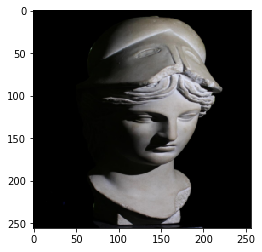

In [11]:
# load data
args.rescale = True
args.scale_h = args.scale_w = 256
args.input_concat_size = 8
args.crop_h = args.crop_w = 256
args.color_aug = False
args.crop = False
args.noise_aug = args.patch_noise = False

val_set = PESELDataset(args, "data/Pesel/", 'val')
sample = next(iter(val_set))
idx = 0
plt.imshow(sample['img'][(3*idx):3*(idx+1)].permute(1,2,0))

In [20]:
with torch.no_grad():
    img_input = (sample['img'])
    normal_hat, merged_features = encoder_net(img_input.unsqueeze(0))
    normal_hat = torch.nn.functional.normalize(normal_hat, dim=1)
    normal_hat = (normal_hat + 1) / 2

    light_hat = light_net(merged_features)
    shadows_hat = shadow_net(merged_features)

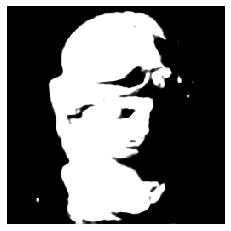

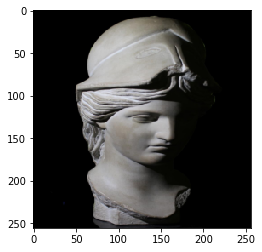

In [18]:
idx=4
fig, ax = plt.subplots()

plt.imshow(shadows_hat[0, idx], cmap="gray")
ax.set_axis_off()

plt.figure()
plt.imshow(sample['img'][(3*idx):3*(idx+1)].permute(1,2,0), alpha=1)
# ax.set_axis_off()
plt.show()